In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

plt.style.use("seaborn-v0_8-whitegrid") 
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
})

In [ ]:
%matplotlib inline

### Gillespie's Algorithm

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

def sir_rhs(t, y, beta, gamma,mu, N):
    """
    Frequency-dependent SIR with COUNTS (X,Y,Z) and fixed population N.
    dX/dt = -beta * X * Y / N
    dY/dt =  beta * X * Y / N - gamma * Y
    dZ/dt =  gamma * Y
    """
    X, Y, Z = y
    
    dX = mu * N - beta * X * Y / N - mu * X
    dY = beta * X * Y / N - gamma * Y - mu * Y
    dZ = gamma * Y - mu * Z
    return [dX, dY, dZ]
    


def integrate_sir(beta, gamma, mu, N, X0, Y0, Z0,
                         t_span=(0.0, 160.0), num_points=1000, method="RK45"):
    """
    Minimal integrator wrapper for counts-based frequency-dependent SIR.
    Returns dict with t, X, Y, Z (arrays).
    """

    y0 = [float(X0), float(Y0), float(Z0)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    sol = solve_ivp(
        lambda t, y: sir_rhs(t, y, beta, gamma, mu, N),
        t_span, y0, t_eval=t_eval, method=method,
        rtol=1e-8, atol=1e-10
    )

    # Numerical safety: clip tiny negatives from solver noise
    
    Y = np.clip(sol.y, 0.0, None)
    return {"t": sol.t, "X": Y[0], "Y": Y[1], "Z": Y[2]}


def gillespie_sir(beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=None):
    """
    infectionL (X - 1, Y + 1), rate_1 = beta * X * Y / N
    recovery: (Y - 1, Z + 1), rate_2 = gamma * Y
    birth:  (X + 1), rate_3 = mu * N
    deathX: (X - 1), rate_4 = mu * X
    deathY: (Y - 1), rate_5 = mu * Y
    deathZ: (Z - 1), rate_6 = mu * Z
    """
    if rng is None:
        rng = np.random.default_rng()

    # Validate & coerce to ints
    
    X, Y, Z = int(X0), int(Y0), int(Z0)
    t = 0.0
    
    times = [0.0]
    X_hist, Y_hist, Z_hist = [X], [Y], [Z]

    while t < tmax and Y > 0:
        rate_I = beta * X * Y / N   # infection
        rate_R = gamma * Y
        rate_B = mu * N              # birth
        rate_DX = mu * X             # death of susceptible
        rate_DY = mu * Y             # death of infected
        rate_DZ = mu * Z             # death of recovered
        total_rate = rate_I + rate_R + rate_B + rate_DX + rate_DY + rate_DZ

        # exponential waiting time
        t += -np.log(rng.random()) /  total_rate

        r  = rng.random() * total_rate
        
        if r < rate_I:
            if X > 0: X -= 1; Y += 1
        elif r < rate_I + rate_R:
            if Y > 0: Y -= 1; Z += 1
        elif r < rate_I + rate_R + rate_B:
            X += 1
        elif r < rate_I + rate_R + rate_B + rate_DX:
            if X > 0: X -= 1
        elif r < rate_I + rate_R + rate_B + rate_DX + rate_DY:
            if Y > 0: Y -= 1
        else:
            if Z > 0: Z -= 1

        times.append(t); X_hist.append(X);Y_hist.append(Y);Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)


In [3]:
def resample_step(times, values, t_grid):
    """Piecewise-constant resampling of an event-driven trajectory."""
    
    out = np.empty_like(t_grid, dtype=float)
    j = 0
    curr = values[0]
    for k, tk in enumerate(t_grid):
        while j + 1 < len(times) and times[j + 1] <= tk:
            j += 1
            curr = values[j]
        out[k] = curr
    return out

In [4]:
# Compare stochastic and deterministic SIR models

beta = 0.5
gamma = 0.1
mu = 1/50
N = 1000
I0 = 10
S0 = N - I0
R0 = 0

t_span = (0.0, 160.0)
num_points = 1000
t_grid = np.linspace(t_span[0], t_span[1], num_points)

# Deterministic solution
det = integrate_sir(beta, gamma, mu, N, S0, I0, R0,
                        t_span=t_span, num_points=num_points)

# Stochastic replicates
n_runs = 200
I_paths = np.zeros((n_runs, num_points), dtype=float)

for r in range(n_runs):
    rng = np.random.default_rng(12345 + r)  # reproducible variety
    times, S_hist, I_hist, R_hist = gillespie_sir(
        beta, gamma, mu, N, S0, I0, R0, tmax=t_span[1], rng=rng
    )
    I_paths[r, :] = resample_step(times, I_hist, t_grid)

I_mean = I_paths.mean(axis=0)

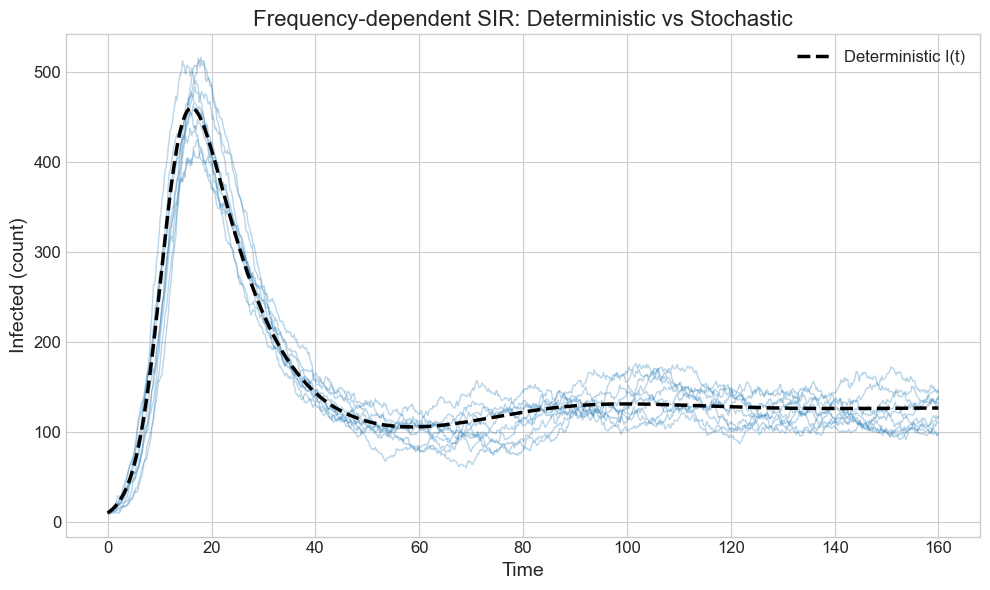

In [5]:
n_show = 10 # number of stochastic runs to show

fig, ax = plt.subplots()
for r in range(n_show):
    ax.plot(t_grid, I_paths[r, :], color="tab:blue", alpha=0.3, lw=1)

# Deterministic
ax.plot(det["t"], det["Y"], "k--", lw=2.5, label="Deterministic I(t)")

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("Infected (count)")
ax.set_title("Frequency-dependent SIR: Deterministic vs Stochastic")
ax.legend()

plt.tight_layout()
plt.show()

### Simulation Variability and Negative Co-variance

In [6]:
def run_ensemble(beta, gamma, mu, N, X0, Y0, Z0,
                 t_span=(0.0, 160.0), num_points=1000,
                 n_runs=200, seed0=12345):
    """
    Runs many Gillespie simulations and the deterministic ODE
    using counts (X,Y,Z). Returns t grid, deterministic curves,
    and stacked X/Y/Z paths.
    """
    # Use the counts-based integrator so keys are X,Y,Z
    det = integrate_sir(beta, gamma, mu, N, X0, Y0, Z0,
                               t_span=t_span, num_points=num_points)
    t_grid = det["t"]

    X_paths = np.zeros((n_runs, num_points))
    Y_paths = np.zeros((n_runs, num_points))
    Z_paths = np.zeros((n_runs, num_points))

    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=t_span[1], rng=rng
        )
        X_paths[r, :] = resample_step(times, X_hist, t_grid)
        Y_paths[r, :] = resample_step(times, Y_hist, t_grid)
        Z_paths[r, :] = resample_step(times, Z_hist, t_grid)

    return t_grid, det, X_paths, Y_paths, Z_paths


In [7]:
def ensemble_stats(X_paths, Y_paths, Z_paths):
    """Compute time-wise mean/variance for X, Y, Z, and Cov[X,Y] (counts)."""
    X_mean = X_paths.mean(axis=0)
    Y_mean = Y_paths.mean(axis=0)
    Z_mean = Z_paths.mean(axis=0)

    X_var  = X_paths.var(axis=0, ddof=1)
    Y_var  = Y_paths.var(axis=0, ddof=1)
    Z_var  = Z_paths.var(axis=0, ddof=1)

    XY_mean = (X_paths * Y_paths).mean(axis=0)
    XY_cov  = XY_mean - X_mean * Y_mean

    return {
        "X_mean": X_mean, "Y_mean": Y_mean, "Z_mean": Z_mean,
        "X_var": X_var,   "Y_var": Y_var,   "Z_var": Z_var,
        "XY_cov": XY_cov
    }

In [8]:
from math import ceil

beta = 0.5
gamma = 0.1
mu = 1/50
t_span = (0, 160)
num_points = 1000
n_runs = 200

N_list = [500, 1000, 2000, 5000, 10000]
I0_fixed = 5
i0_frac = I0_fixed / 5000

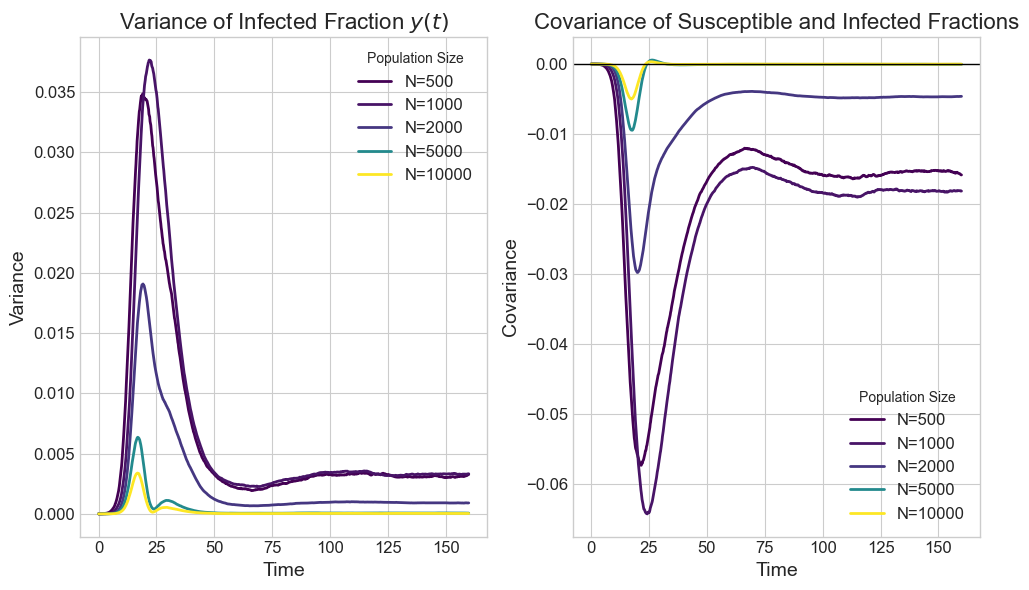

In [9]:
fig, (ax_var, ax_cov) = plt.subplots(1, 2)

Nmin, Nmax = min(N_list), max(N_list)

for N in N_list:
    # fixed initial fraction
    Y0 = max(1, int(ceil(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    t, det, X_paths, Y_paths, Z_paths = run_ensemble(
        beta, gamma, mu, N, X0, Y0, Z0,
        t_span=t_span, num_points=num_points, n_runs=n_runs, seed0=6000
    )

    # convert to fractions
    y_paths = Y_paths / N
    x_paths = X_paths / N

    # normalized stats
    y_var = y_paths.var(axis=0, ddof=1)
    xy_mean = (x_paths * y_paths).mean(axis=0)
    xy_cov = xy_mean - x_paths.mean(axis=0) * y_paths.mean(axis=0)

    color = plt.cm.viridis((N - Nmin) / (Nmax - Nmin))

    # Variance of infected fraction
    ax_var.plot(t, y_var, color=color, label=f"N={N}")
    
    # Covariance of susceptible vs infected fractions
    ax_cov.plot(t, xy_cov, color=color, label=f"N={N}")

ax_cov.axhline(0, color="k", lw=1)

ax_var.set_title("Variance of Infected Fraction $y(t)$")
ax_var.set_xlabel("Time"); ax_var.set_ylabel("Variance")

ax_cov.set_title("Covariance of Susceptible and Infected Fractions")
ax_cov.set_xlabel("Time"); ax_cov.set_ylabel("Covariance")

ax_var.legend(title="Population Size")
ax_cov.legend(title="Population Size")

plt.tight_layout()
plt.show()

In [10]:
from scipy.signal import  find_peaks

def find_sir_equilibrium(beta, gamma, mu, N):
    """Find the endemic equilibrium for SIR with demography."""
    R0 = beta / (gamma + mu)
    if R0 <= 1.0:
        return (N, 0, 0) 
    else:
        X_eq = N / R0
        Y_eq = mu * N * (R0 - 1) / beta
        Z_eq = N - X_eq - Y_eq
        return (X_eq, Y_eq, Z_eq)

In [11]:
def compute_psd(y_signal, dt):
    """
    FFT-based PSD with correct one-sided normalization.
    Uses second half (steady-state), mean removal, Hann window.
    Returns freqs (1/time) and PSD with units 'power per (1/time)'.
    """
    # Steady-state half
    mid = len(y_signal) // 2
    y_steady = y_signal[mid:]

    # Detrend (mean) and window
    y_centered = y_steady - np.mean(y_steady)
    window = np.hanning(len(y_centered))
    y_windowed = y_centered * window

    # FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(len(y_windowed), d=dt)

    Fs = 1.0 / dt
    psd = (np.abs(fft_vals) ** 2) / (Fs * np.sum(window ** 2))

    if len(psd) > 2:
        psd[1:-1] *= 2

    return freqs, psd

In [12]:
def analyze_resonance(beta, gamma, mu, N, n_runs=30, tmax=400):
    """
    Analyze stochastic resonance: run simulations and compute averaged PSD.
    """
    # Setup
    t_grid = np.linspace(0, tmax, 4000)
    dt = t_grid[1] - t_grid[0]
    X_eq, Y_eq, Z_eq = find_sir_equilibrium(beta, gamma, mu, N)

    X0, Y0, Z0 = int(X_eq), max(1, int(Y_eq)), int(Z_eq)

    all_psds = []
    all_trajectories = []

    for run in range(n_runs):
        rng = np.random.default_rng(1000 + run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax, rng=rng
        )
        Y_uniform = resample_step(times, Y_hist, t_grid)
        all_trajectories.append(Y_uniform)

        freqs, psd = compute_psd(Y_uniform / N, dt)
        all_psds.append(psd)

    avg_psd = np.mean(all_psds, axis=0)

    f_nyq = 0.5 / dt
    f_low = 1.0 / tmax             
    f_high = min(0.1, 0.9 * f_nyq)
    mask = (freqs >= f_low) & (freqs <= f_high)
    
    peak_freq = None
    peak_power = None
    if np.any(mask):
        prom = np.percentile(avg_psd[mask], 85)
        peaks, properties = find_peaks(
            avg_psd[mask],
            prominence=max(1e-12, prom),
            width=1 
        )
        if len(peaks) > 0:
            masked_psd = avg_psd[mask]
            best = peaks[np.argmax(masked_psd[peaks])]
            peak_freq = freqs[mask][best]
            peak_power = masked_psd[best]

    return {
        'freqs': freqs,
        'avg_psd': avg_psd,
        'peak_freq': peak_freq,
        'peak_power': peak_power,
        'trajectories': all_trajectories,
        't_grid': t_grid,
        'Y_eq': Y_eq
    }

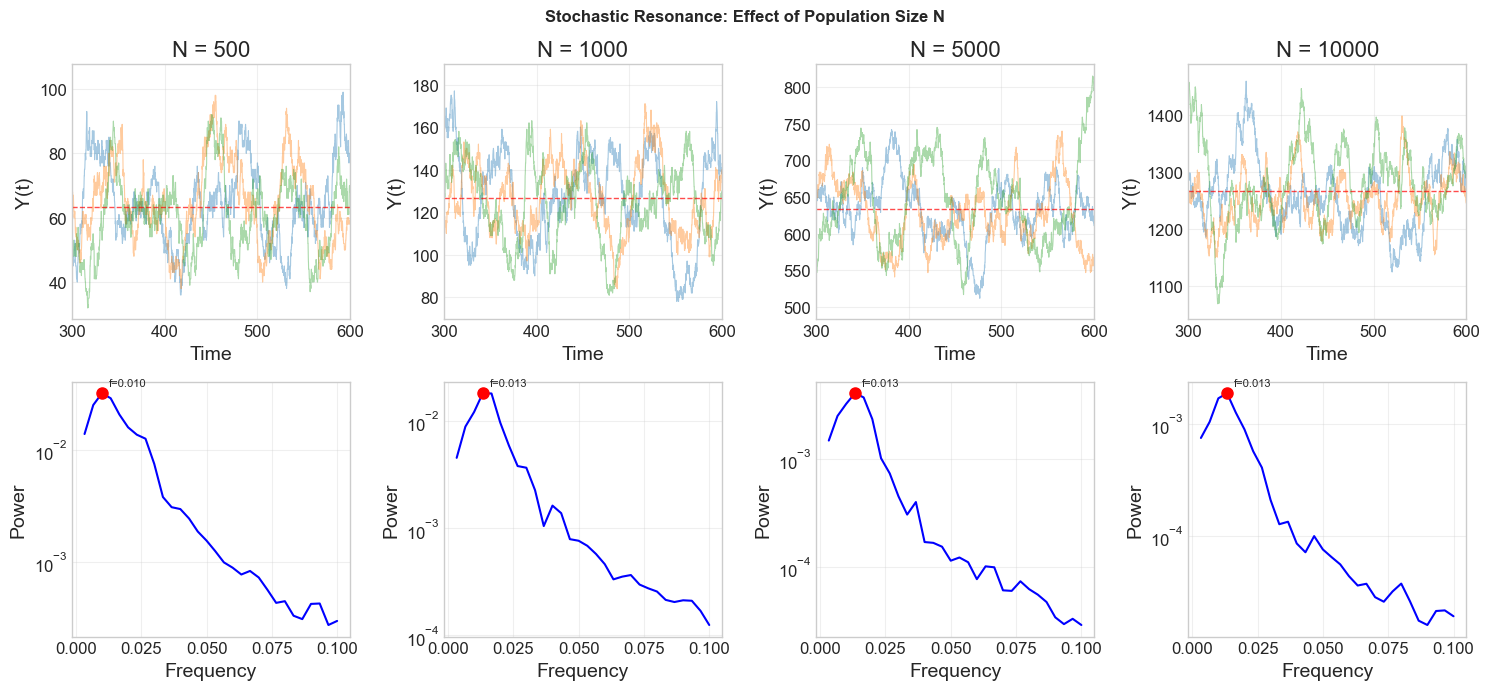

In [14]:
gamma = 0.1
mu = 1/50
N_values = [500, 1000, 5000, 10000]
beta = 0.5

fig, axes = plt.subplots(2, len(N_values), figsize=(15, 7))

resonance_results = []
for idx, N in enumerate(N_values):
    res = analyze_resonance(beta, gamma, mu, N, n_runs=20, tmax=600)
    resonance_results.append(res)
    
    # Top: Sample trajectories
    ax = axes[0, idx]
    for i in range(min(3, len(res['trajectories']))):
        ax.plot(res['t_grid'], res['trajectories'][i], alpha=0.4, lw=0.8)
    ax.axhline(res['Y_eq'], ls='--', lw=1.0, alpha=0.7, color='red', label='Y*')
    ax.set_title(f'N = {N}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Y(t)')
    ax.set_xlim([300, 600])
    ax.grid(True, alpha=0.3)
    
    # Bottom: Power spectrum
    ax = axes[1, idx]
    mask = (res['freqs'] > 0) & (res['freqs'] < 0.1)
    ax.semilogy(res['freqs'][mask], res['avg_psd'][mask], 'b-', lw=1.5)
    
    if res['peak_freq'] is not None:
        ax.plot(res['peak_freq'], res['peak_power'], 'ro', markersize=8)
        ax.annotate(f"f={res['peak_freq']:.3f}", 
                   xy=(res['peak_freq'], res['peak_power']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Power')
    ax.grid(True, alpha=0.3)

plt.suptitle('Stochastic Resonance: Effect of Population Size N', fontweight='bold')
plt.tight_layout()
plt.show()

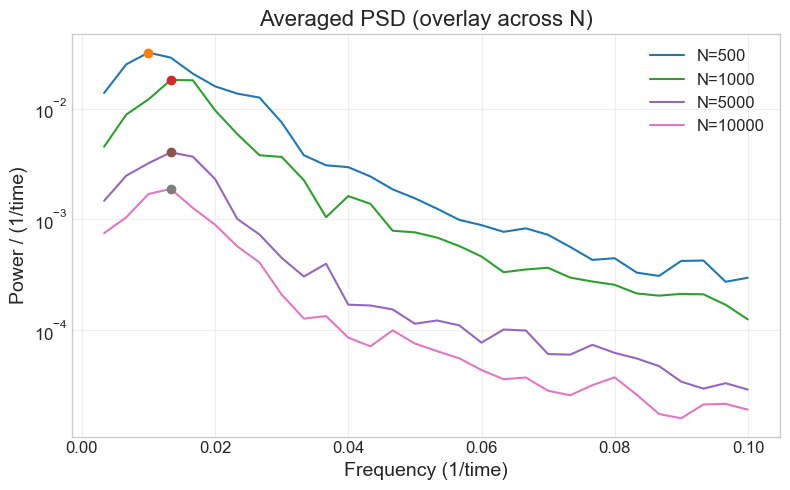

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
for N, res in zip(N_values, resonance_results):
    f_low, f_high = 1/res['t_grid'][-1], 0.1
    mask = (res['freqs'] >= f_low) & (res['freqs'] <= f_high)
    ax.semilogy(res['freqs'][mask], res['avg_psd'][mask], lw=1.5, label=f'N={N}')
    if res['peak_freq'] is not None:
        ax.plot(res['peak_freq'], res['peak_power'], 'o')

ax.set_xlabel('Frequency (1/time)')
ax.set_ylabel('Power / (1/time)')
ax.set_title('Averaged PSD (overlay across N)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout(); plt.show()

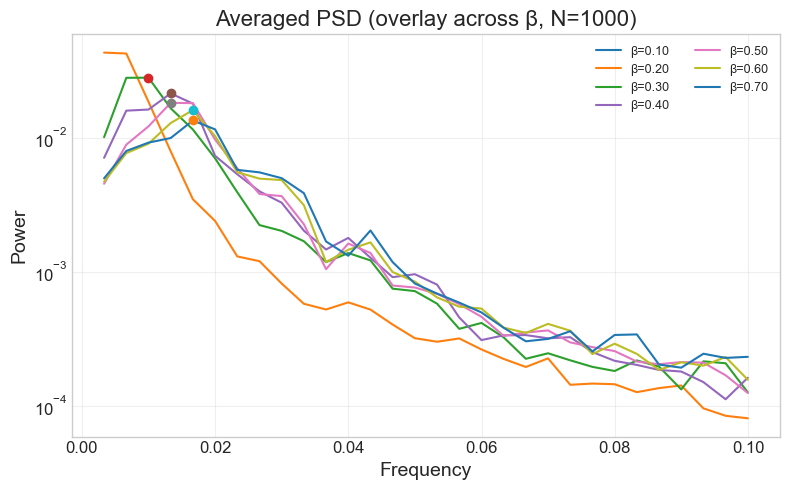

In [16]:
N_fixed = 1000
beta_grid = np.arange(0.1, 0.71, 0.1) 
psd_by_beta = []

for b in beta_grid:
    res = analyze_resonance(b, gamma, mu, N_fixed, n_runs=20, tmax=600)
    psd_by_beta.append(res)

fig, ax = plt.subplots(figsize=(8,5))
for b, res in zip(beta_grid, psd_by_beta):
  
    f_low, f_high = 1/res['t_grid'][-1], 0.1
    mask = (res['freqs'] >= f_low) & (res['freqs'] <= f_high)
    ax.semilogy(res['freqs'][mask], res['avg_psd'][mask], lw=1.5, label=f'β={b:.2f}')
    if res['peak_freq'] is not None:
        ax.plot(res['peak_freq'], res['peak_power'], 'o')

ax.set_xlabel('Frequency')
ax.set_ylabel('Power')
ax.set_title(f'Averaged PSD (overlay across β, N={N_fixed})')
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout(); plt.show()

In [39]:
from joblib import Parallel, delayed

def analyze_transients_around_eq(beta, gamma, mu, N,
                                 n_runs=40, tmax=800, num_points=2000,
                                 burn_frac=0.5, seed0=2000):
    eq = find_sir_equilibrium(beta, gamma, mu, N)
    if eq is None:
        return np.nan
    X_star, Y_star, Z_star = eq

    X0 = max(0, int(round(X_star)))
    Y0 = max(1, int(round(Y_star)))
    Z0 = max(0, int(round(Z_star)))

    t_grid = np.linspace(0.0, tmax, num_points)
    burn = int(burn_frac * num_points)

    overs = []
    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )
        Y_uni = resample_step(times, Y_hist, t_grid)  # counts
        peak_ss = float(np.max(Y_uni[burn:]))         # stationary window only
        os = max(0.0, (peak_ss - Y_star) / N)
        overs.append(os)

    return float(np.mean(overs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  3.5min remaining:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


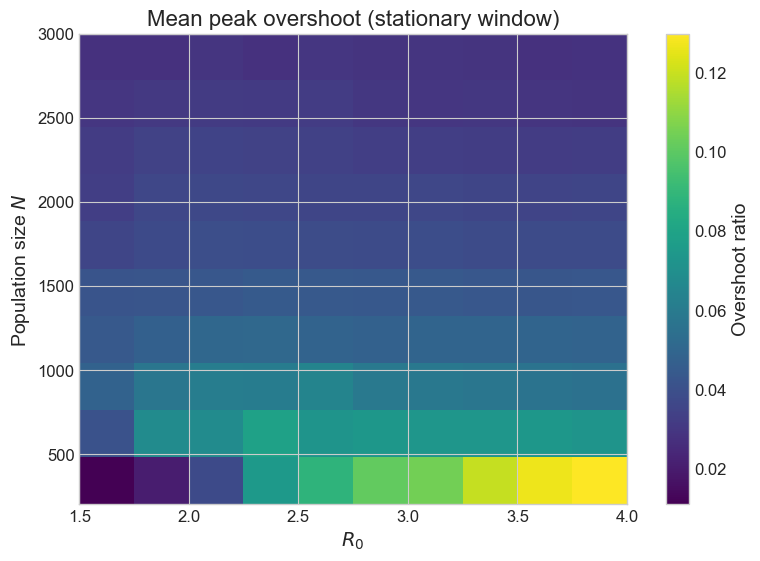

In [45]:
def sweep_mean_overshoot(N_grid, R0_grid, gamma, mu, n_runs=40, tmax=800,
                         num_points=2000, burn_frac=0.5, n_jobs=-1):
    params = [(N, R0) for N in N_grid for R0 in R0_grid]

    def run_point(N, R0):
        if R0 <= 1.0:
            return np.nan
        beta = R0 * (gamma + mu)
        return analyze_transients_around_eq(
            beta, gamma, mu, N, n_runs=n_runs, tmax=tmax,
            num_points=num_points, burn_frac=burn_frac
        )

    vals = Parallel(n_jobs=n_jobs, verbose = 10, prefer="processes")(
        delayed(run_point)(N, R0) for (N, R0) in params
    )

    M, B = len(N_grid), len(R0_grid)
    return np.array(vals).reshape(M, B)

gamma, mu = 0.1, 1/50
N_grid    = np.linspace(200, 3000, 10, dtype=int)
R0_grid   = np.linspace(1.5, 10, 10)

mean_os = sweep_mean_overshoot(
    N_grid, R0_grid, gamma, mu,
    n_runs=40, tmax=800, num_points=2000, burn_frac=0.5, n_jobs=-1
)

fig, ax = plt.subplots(figsize=(7.5, 5.5), constrained_layout=True)

im = ax.imshow(mean_os, origin='lower', aspect='auto',
               extent=[R0_grid[0], R0_grid[-1], N_grid[0], N_grid[-1]],
               cmap='viridis')
ax.set_title("Mean peak overshoot (stationary window)")
ax.set_xlabel(r"$R_0$")
ax.set_ylabel("Population size $N$")
c = plt.colorbar(im, ax=ax); c.set_label("Overshoot ratio")

plt.show()

Equilibrium at N=100000, R0=4.0: (25000.0, 12499.999999999998, 62500.0)
Y* = 12500.00, Y0 = 12500


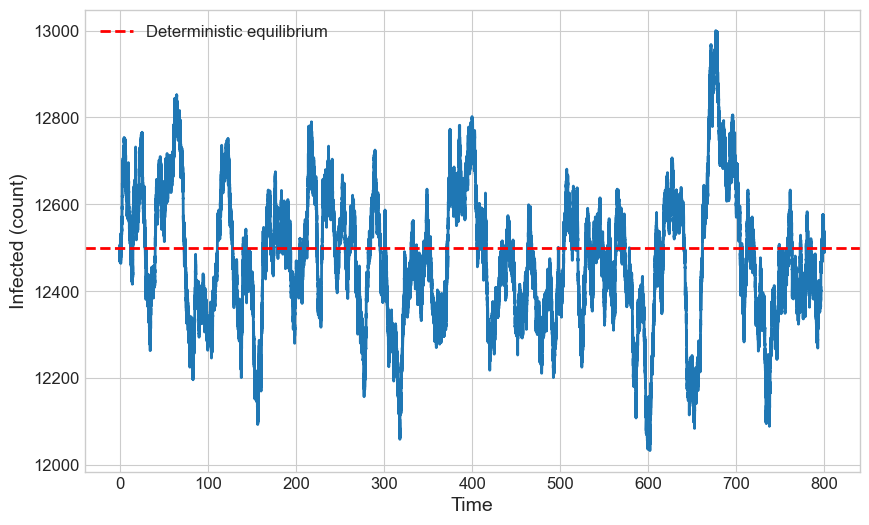

In [44]:
N, R0 = 100000, 4.0
beta = R0 * (gamma + mu)
eq = find_sir_equilibrium(beta, gamma, mu, N)
print(f"Equilibrium at N={N}, R0={R0}: {eq}")
print(f"Y* = {eq[1]:.2f}, Y0 = {max(1, int(round(eq[1])))}")

# Run one trajectory and plot it
rng = np.random.default_rng(2000)
times, X_hist, Y_hist, Z_hist = gillespie_sir(beta, gamma, mu, N, 
                                                int(eq[0]), max(1,int(eq[1])), int(eq[2]),
                                                tmax=800, rng=rng)
plt.xlabel("Time")
plt.ylabel("Infected (count)")
plt.plot(times, Y_hist)
plt.axhline(eq[1], color='red', linestyle='--', label='Deterministic equilibrium')
plt.legend()
plt.show()

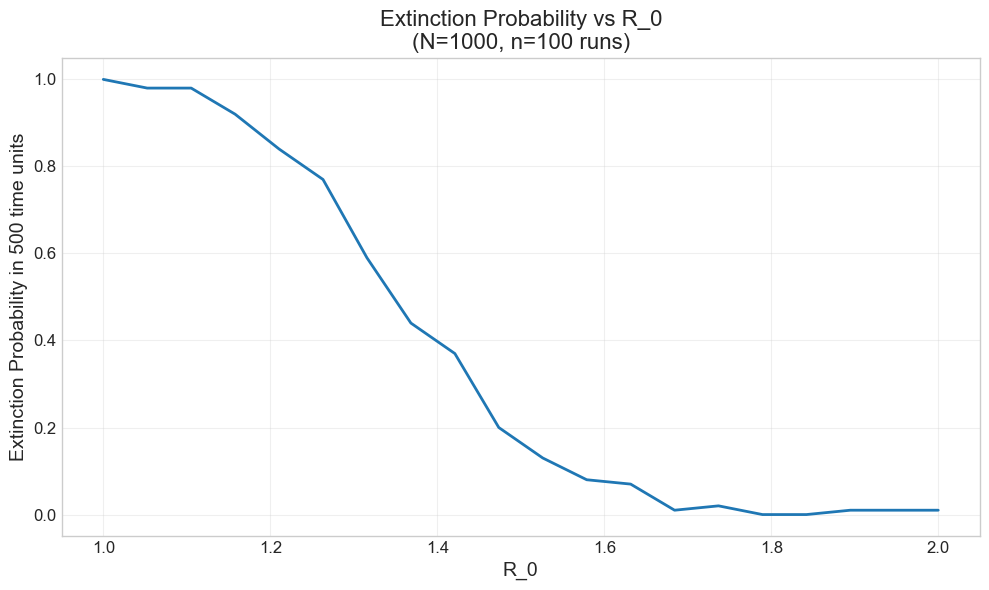

In [12]:
# We create a range of R_0 values (> 1) by varying beta keeping gamma and mu fixed
R0 = np.linspace(1, 2, 20)
gamma = 0.1
mu = 1/50
beta = [R0_i * (gamma + mu) for R0_i in R0]
N = 1000
X0 = np.round(0.05*N)
Y0 = N - X0
Z0 = 0
seed0 = 42

# Create an experiment that runs the gillespie simulation for the differnt R_0 values each n times for statistical significance. Per simulation count the number of extinctions, and the time to extiction. Take the averages over the runs and plot them against the values of R_0

n_runs = 100 # Number of simulations per R0 value
tmax = 500.0  # Maximum simulation time

# Storage for results
mean_extinction_counts = []
mean_extinction_times = []


for idx, (R0_val, beta_val) in enumerate(zip(R0, beta)):
    extinctions = []
    extinction_times = []
    
    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0+run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N, X0, Y0, Z0, tmax=tmax, rng=rng
        )
        
        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else: 
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(R0, mean_extinction_counts, linewidth=2)
ax.set_xlabel('R_0')
ax.set_ylabel('Extinction Probability in 500 time units')
ax.set_title(f'Extinction Probability vs R_0\n(N={N}, n={n_runs} runs)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()


In [24]:
# We create a range of R_0 values (> 1) by varying beta keeping gamma and mu fixed
R0 = 1.3
gamma = 0.1
mu = 1/50
beta = R0 * (gamma + mu)
N = np.linspace(500, 6000, 20, dtype=int)
X0 = 50
Y0 = [N_val - X0 for N_val in N]
Z0 = 0
seed0 = 42

# Create an experiment that runs the gillespie simulation for the differnt R_0 values each n times for statistical significance. Per simulation count the number of extinctions, and the time to extiction. Take the averages over the runs and plot them against the values of R_0

n_runs = 100 # Number of simulations per R0 value
tmax = 500.0  # Maximum simulation time

# Storage for results
mean_extinction_counts = []
mean_extinction_times = []


for idx, (N_val, Y0_val) in enumerate(zip(N, Y0)):
    extinctions = []
    extinction_times = []
    
    for run in range(n_runs):
        rng = np.random.default_rng(seed=seed0+run)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, mu, N_val, X0, Y0_val, Z0, tmax=tmax, rng=rng
        )
        
        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]

        if len(extinction_idx) > 0:
            extinctions.append(1)
        else: 
            extinctions.append(0)

    mean_extinction_counts.append(np.mean(extinctions))

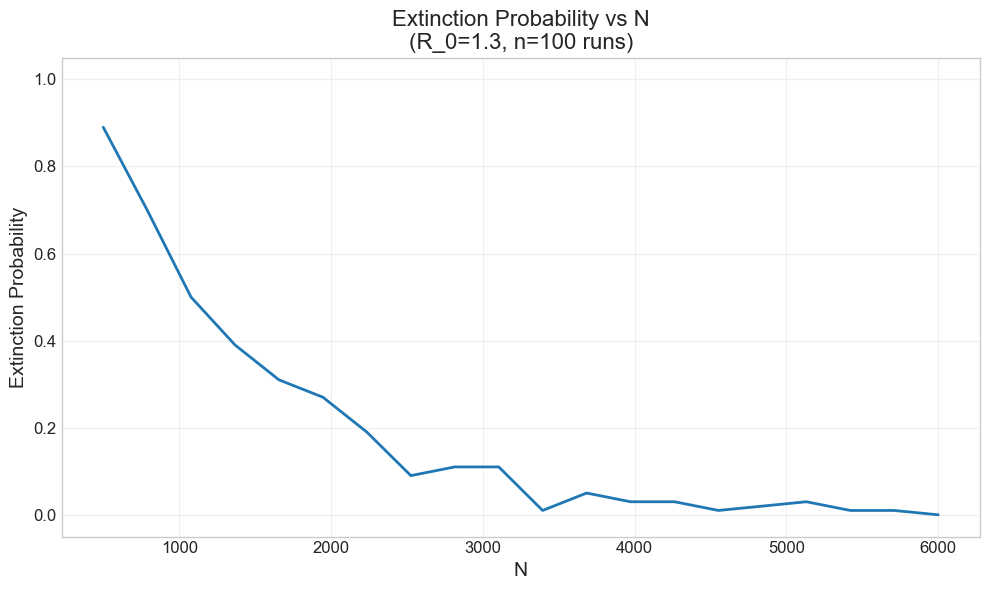

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(N, mean_extinction_counts, linewidth=2)
ax.set_xlabel('N')
ax.set_ylabel('Extinction Probability')
ax.set_title(f'Extinction Probability vs N\n(R_0={R0}, n={n_runs} runs)')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

In [ ]:
from joblib import Parallel, delayed

def run_parameter_combination(R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed):
    """
    Run simulations for a single (R0, N) parameter combination.
    Returns extinction probability for that combination.
    """
    extinctions = []
    Y0_val = N_val - X0
    Z0_val = 0
    
    for run in range(n_runs):
        # Use unique seed for each run
        seed = base_seed + run * 10000
        rng = np.random.default_rng(seed=seed)
        
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta_val, gamma, mu, N_val, X0, Y0_val, Z0_val, tmax=tmax, rng=rng
        )
        
        # Check if extinction occurred (Y reached 0 before tmax)
        extinction_idx = np.where(Y_hist == 0)[0]
        
        if len(extinction_idx) > 0:
            extinctions.append(1)
        else: 
            extinctions.append(0)
    
    return np.mean(extinctions)

# Create heatmap of extinction probabilities varying N and R0 - JOBLIB VERSION
gamma = 0.1
mu = 1/50
seed0 = 42

# Define parameter ranges
N_values = np.linspace(500, 5000, 10, dtype=int)  # Population sizes
R0_values = np.linspace(1, 2, 10)  # R0 values
beta_values = [R0_val * (gamma + mu) for R0_val in R0_values]

# Fixed parameters
X0 = 50  # Initial infected
tmax = 500.0  # Maximum simulation time
n_runs = 50  # Runs per parameter combination

# Prepare parameter combinations for joblib
param_combinations = []
combo_id = 0

for i, R0_val in enumerate(R0_values):
    beta_val = beta_values[i]
    for j, N_val in enumerate(N_values):
        # Create unique base seed for each parameter combination
        base_seed = seed0 + combo_id * 1000
        
        param_combinations.append((i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed))
        combo_id += 1

# Run multiprocessing with joblib

# Use joblib with all available cores and progress tracking
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_parameter_combination)(R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed) for i, j, R0_val, N_val, beta_val, gamma, mu, X0, tmax, n_runs, base_seed in param_combinations
)

# Reconstruct heatmap from results
extinction_heatmap = np.zeros((len(R0_values), len(N_values)))

for (i, j, *_), result in zip(param_combinations, results):
    extinction_heatmap[i, j] = result



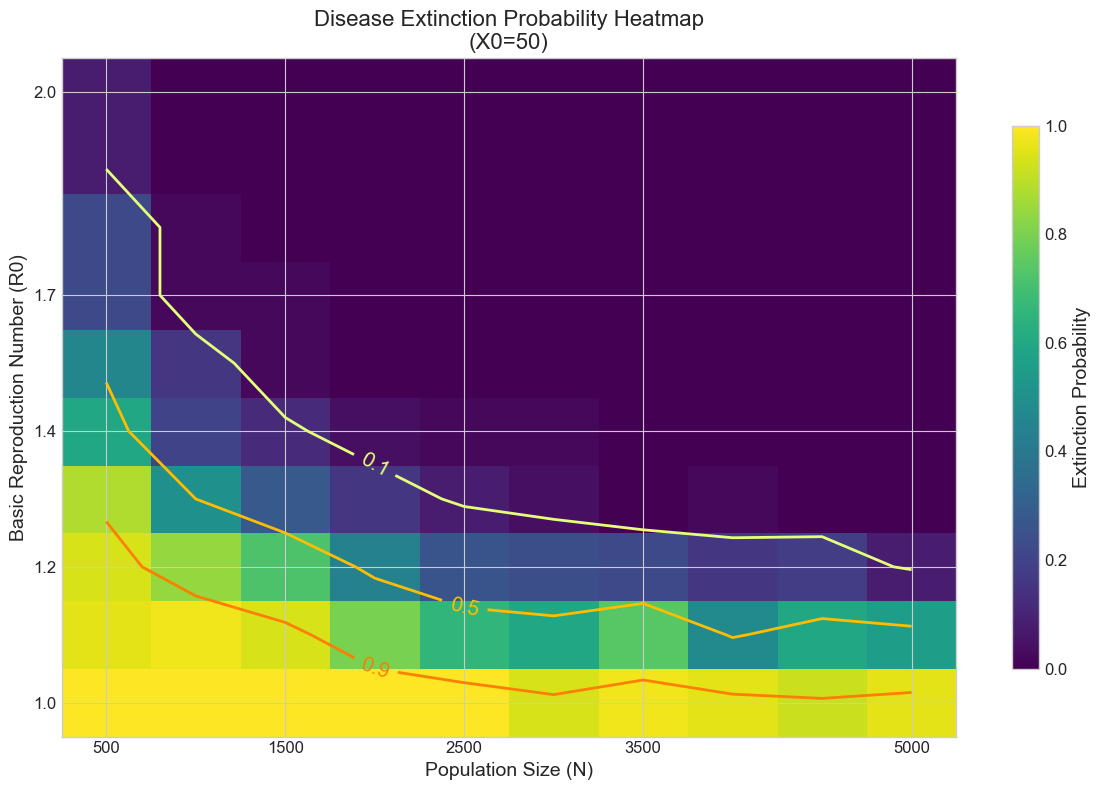

In [62]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(extinction_heatmap, 
               cmap='viridis',  
               aspect='auto',
               origin='lower',
               vmin=0, vmax=1)

# Set ticks and labels
n_ticks = 5
r0_tick_indices = np.linspace(0, len(R0_values)-1, n_ticks, dtype=int)
n_tick_indices = np.linspace(0, len(N_values)-1, n_ticks, dtype=int)

ax.set_xticks(n_tick_indices)
ax.set_xticklabels([f'{N_values[i]:.0f}' for i in n_tick_indices])
ax.set_yticks(r0_tick_indices)
ax.set_yticklabels([f'{R0_values[i]:.1f}' for i in r0_tick_indices])

# Labels and title
ax.set_xlabel('Population Size (N)')
ax.set_ylabel('Basic Reproduction Number (R0)')
ax.set_title(f'Disease Extinction Probability Heatmap\n(X0={X0})')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Extinction Probability')

# Add contour lines for specific extinction probabilities
contour_levels = [0.1, 0.5, 0.9]
contours = ax.contour(extinction_heatmap, levels=contour_levels, cmap='Wistia', linewidths=2)
ax.clabel(contours, inline=True, fontsize=15, fmt='%.1f')

plt.tight_layout()
plt.show()

### Spatial Models

In [59]:
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from __future__ import annotations
from typing import Dict, List, Tuple, Optional
import networkx as nx

In [93]:
class NetworkSimulator:
    def __init__(self, seed: int = 42):
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.network_types: List[str] = ['erdos_renyi', 'barabasi_albert', 'watts_strogatz']
        self.networks: Dict[str, List[nx.Graph]] = {}
        self.experiment_results: Optional[pd.DataFrame] = None
        
        
    @staticmethod
    def _set_mean_degree(n_nodes: int, target_k: float) -> Tuple[float, int, int]:
        """
        Given n and desired mean degree <k>, return:
          ER: p
          BA: m
          WS: k_even
        """
        if n_nodes <= 1:
            p = 0.0
        else:
            p = target_k / (n_nodes - 1)
        p = float(np.clip(p, 0.0, 1.0))

        m = int(round(target_k / 2.0))
        m = max(1, min(m, n_nodes - 1))

        k = int(round(target_k))
        k = min(k, n_nodes - 1)
        if k % 2:  # make it even
            k = k - 1 if k > 1 else 2
        k = max(2, min(k, n_nodes - 2))

        return p, m, k
    
    @staticmethod
    def _spectral_radius(G: nx.Graph) -> float:
        """
        Largest eigenvalue of adjacency (for network-aware threshold).
        """
        A = nx.to_numpy_array(G, dtype=float)
        # eigenvalues may be complex due to numerical noise; take real part
        vals = np.linalg.eigvals(A)
        return float(np.max(vals.real))

    
    # Networks
    
    def generate_networks(
        self, 
        n_nodes: int = 100,
        n_instances: int = 5, 
        target_k: float = 6.0, 
        ws_p: float = 0.3
        ) -> Dict[str, List[nx.Graph]]:
        """
        Generate and store networks of each type with given parameters.
        Stores them in self.networks and returns the dict.
        """
        p, m, k = self._set_mean_degree(n_nodes, target_k)
        print(f"[Generate] N={n_nodes}, instances={n_instances}, target ⟨k⟩={target_k:.2f}")
        print(f"  ER: p={p:.4f}   BA: m={m}   WS: k={k}, p_rewire={ws_p}")

        self.networks = {t: [] for t in self.network_types}
        
        for i in range(n_instances):
            base = self.seed + i
            
            G_er = nx.erdos_renyi_graph(n_nodes, p, seed=base)
            self.networks['erdos_renyi'].append(G_er)
            
            G_ba = nx.barabasi_albert_graph(n_nodes, m, seed=base)
            self.networks['barabasi_albert'].append(G_ba)
            
            G_ws = nx.watts_strogatz_graph(n_nodes, k, ws_p, seed=base)
            self.networks['watts_strogatz'].append(G_ws)
            
            
        # Sanity Check
        
        for t in self.network_types:
            means = []
            for G in self.networks[t]:
                degs = [d for _, d in G.degree()]
                means.append(np.mean(degs))
            print(f"  {t.replace('_',' ').title():>16}: realized ⟨k⟩ = {np.mean(means):.2f} ± {np.std(means):.2f}")

        return self.networks
    
    def compute_network_stats(self, G: nx.Graph) -> Dict[str, float]:
        """
        Compute and return basic network statistics.
        
        Params:
        - size: n_nodes, n_edges, density, n_components, lcc_frac
        - degree: avg_degree, std_degree, min_degree, max_degree
        - clustering: avg_clustering, transitivity
        - distances on LCC: avg_distance, diameter (what perentage of the network is connected)
        - centrality: avg_betweenness (what even is this?)
        """
        stats: Dict[str, float] = {}
        
        # Size
        n = G.number_of_nodes()
        m = G.number_of_edges()
        stats['n_nodes'] = n
        stats['n_edges'] = m
        stats['density'] = nx.density(G)
        
         # Degree
        degs = np.fromiter((d for _, d in G.degree()), dtype=float, count=n)
        stats['avg_degree'] = float(degs.mean()) if n else 0.0
        stats['std_degree'] = float(degs.std()) if n else 0.0
        stats['min_degree'] = float(degs.min()) if n else 0.0
        stats['max_degree'] = float(degs.max()) if n else 0.0
        
        if n == 0:
            stats.update({
                'n_components': 0, 'lcc_frac': 0.0,
                'avg_path_length': np.nan, 'diameter': np.nan,
            })
            return stats
        
        if nx.is_connected(G):
            H = G
            stats['n_components'] = 1
            stats['lcc_frac'] = 1.0
        else:
            components = sorted(nx.connected_components(G), key=len, reverse=True)
            H = G.subgraph(components[0]).copy()
            stats['n_components'] = nx.number_connected_components(G)
            stats['lcc_frac'] = len(H) / n

        # Clustering
        
        if H.number_of_nodes() > 1:
            stats['avg_path_length'] = nx.average_shortest_path_length(H)
            stats['diameter'] = nx.diameter(H)
        else:
            stats['avg_path_length'] = 0.0
            stats['diameter'] = 0.0
            
        k_sample = min(100, n)
        bet = nx.betweenness_centrality(G, k=k_sample, seed=self.seed)
        stats['avg_betweenness'] = float(np.mean(list(bet.values()))) if bet else 0.0

        return stats
    

    def visualize_network_stats(self) -> None:
        """
        Compare ER/BA/WS via boxplots of selected metrics and degree distributions.
        Assumes self.networks has been populated.
        """
        import matplotlib.pyplot as plt

        if not self.networks:
            print("No networks stored")
            return

        # Collect stats
        all_stats = {t: [] for t in self.network_types}
        for t in self.network_types:
            for G in self.networks[t]:
                all_stats[t].append(self.compute_network_stats(G))

        # Only these metrics
        metrics = [
            ('avg_degree', 'Average Degree'),
            ('avg_path_length', 'Average Path Length (LCC)'),
            ('std_degree', 'Degree Std Dev'),
            ('density', 'Density'),
        ]

        # Dynamic subplot grid
        n_metrics = len(metrics)
        n_cols = 2
        n_rows = int(np.ceil(n_metrics / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for ax, (key, label) in zip(axes, metrics):
            data = [[s[key] for s in all_stats[t]] for t in self.network_types]
            labels = [t.replace('_', ' ').title() for t in self.network_types]
            bp = ax.boxplot(data, labels=labels, patch_artist=True)
            for patch, c in zip(bp['boxes'], ['#8ecae6', '#bde0fe', '#ffc8dd']):
                patch.set_facecolor(c)
                patch.set_alpha(0.85)
            ax.set_title(label)
            ax.grid(True, alpha=0.3)

        # Hide any unused subplots
        for j in range(len(metrics), len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Network Statistics Comparison", fontweight='bold')
        plt.tight_layout()
        plt.show()

        # Degree distributions
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        for ax, t in zip(axes, self.network_types):
            degrees = []
            for G in self.networks[t]:
                degrees.extend([d for _, d in G.degree()])
            ax.hist(degrees, bins=30, edgecolor='black', alpha=0.75)
            ax.set_title(t.replace('_', ' ').title())
            ax.set_xlabel("Degree")
            ax.set_ylabel("Frequency")
            ax.grid(True, alpha=0.3)

            if t == 'barabasi_albert' and len(degrees) > 0:
                counts = np.bincount(degrees)
                k = np.arange(len(counts))
                mask = counts > 0
                inset = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
                inset.loglog(k[mask], counts[mask], 'o', ms=3)
                inset.set_title("Log–log", fontsize=8)
                inset.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    
    # Simulations
    
    def run_sir_simulation(
        self,
        G: nx.Graph,
        beta: float = 0.5,
        gamma: float = 0.1,
        fraction_infected: float = 0.05,
        iterations: int = 200,
        seed: Optional[int] = None,
        ) -> Dict[str, object]:
        """
        Run one NDLib SIR simulation on graph G and return results + summary metrics.
        """
        if seed is not None:
            np.random.seed(seed)

        # Configure model
        model = ep.SIRModel(G)
        config = mc.Configuration()
        config.add_model_parameter('beta', float(beta))
        config.add_model_parameter('gamma', float(gamma))
        config.add_model_parameter('fraction_infected', float(fraction_infected))
        model.set_initial_status(config)

        # Run simulation
        iters = model.iteration_bunch(iterations)          # list of iteration dicts
        trends = model.build_trends(iters)                 

        # Map status names -> integer codes (preferred)
        if hasattr(model, 'available_statuses'):
            s2i = model.available_statuses                 # {'Susceptible':0,'Infected':1,'Removed':2}
        else:
            # Fallback: use the canonical SIR codes from docs
            s2i = {'Susceptible': 0, 'Infected': 1, 'Removed': 2}

        I_idx = s2i['Infected']
        R_idx = s2i['Removed']

        node_count = trends[0]['trends']['node_count']     
        infected = np.asarray(node_count[I_idx], dtype=float)
        removed  = np.asarray(node_count[R_idx], dtype=float)

        # Metrics
        peak_infected = float(infected.max())
        time_to_peak  = int(infected.argmax())
        final_recovered = float(removed[-1])

        N = G.number_of_nodes()
        lam1 = self._spectral_radius(G)
        R0_naive = (beta / gamma) if gamma > 0 else float('inf')
        R0_network = R0_naive * lam1

        return {
            'model': model,
            'trends': trends,
            'iterations': iters,
            'beta': beta,
            'gamma': gamma,
            'fraction_infected': fraction_infected,
            'n_nodes': N,
            'lambda1': lam1,
            'R0_naive': R0_naive,
            'R0_network': R0_network,
            'peak_infected': peak_infected,
            'time_to_peak': time_to_peak,
            'final_recovered': final_recovered,
            'peak_frac': peak_infected / N if N else np.nan,
            'final_size_frac': final_recovered / N if N else np.nan,
        }
        
    
    def experiment_parameter_sweep(
        self,
        n_repetitions: int = 5,
        beta_values: Optional[List[float]] = None,
        gamma_values: Optional[List[float]] = None,
    ) -> pd.DataFrame:
        """
        Sweep (beta, gamma) across network types and replicate.
        Store results in self.experiment_results and return a DataFrame.
        """
        if not self.networks:
            raise RuntimeError("No networks stored")
        
        if beta_values is None:
            beta_values = [0.05, 0.1, 0.2]
        if gamma_values is None:
            gamma_values = [0.02, 0.05, 0.1]
            
        rows = []
        for network_type in self.network_types:
            nets = self.networks[network_type]
            for beta in beta_values:
                for gammma in gamma_values:
                    for r in range(n_repetitions):
                        idx = int(self.rng.integers(0, len(nets)))
                        G = nets[idx]
                        res = self.run_sir_simulation(
                            G, beta=beta, gamma=gammma, 
                            fraction_infected=0.05, iterations=200,
                            seed=self.seed + r
                        )
                        rows.append({
                            'network_type': network_type,
                            'beta': beta,
                            'gamma': gamma,
                            'R0_naive': res['R0_naive'],
                            'lambda1': res['lambda1'],
                            'R0_network': res['R0_network'],
                            'peak_infected': res['peak_infected'],
                            'final_recovered': res['final_recovered'],
                            'time_to_peak': res['time_to_peak'],
                            'peak_frac': res['peak_frac'],
                            'final_size_frac': res['final_size_frac'],
                            'n_nodes': res['n_nodes'],
                            'rep': r,
                            'net_idx': idx,
                        })
        self.experiment_results = pd.DataFrame(rows)
        return self.experiment_results
    
    def experiment_initial_conditions(
        self,
        beta: float = 0.5,
        gamma: float = 0.1,
        iterations: int = 200,
        fractions: List[float] = [0.01, 0.05, 0.1],
        repetitions: int = 5,
    ) -> pd.DataFrame:
        """
        Compare seeding strategies: random, high-degree, low-degree, clustered.
        """ 
        if not self.networks:
            raise RuntimeError("No networks stored")
        
        strategies = {
            'random': self._infect_random,
            'high_degree': self._infect_high_degree,
            'low_degree': self._infect_low_degree,
        }
        
        rows = []
        for net_type in self.network_types:
            for frac in fractions:
                for strat_name, strat_fn in strategies.items():
                    for rep in range(repetitions):
                        G = self.networks[net_type][rep % len(self.networks[net_type])]

                        model = ep.SIRModel(G)
                        cfg = mc.Configuration()
                        cfg.add_model_parameter('beta', float(beta))
                        cfg.add_model_parameter('gamma', float(gamma))

                        infected0 = strat_fn(G, frac)
                        for u in G.nodes():
                            # SIR codes: S=0, I=1, R=2 (NDLib default)
                            cfg.add_node_configuration("status", u, 1 if u in infected0 else 0)

                        model.set_initial_status(cfg)
                        its = model.iteration_bunch(iterations)
                        trends = model.build_trends(its)

                        # robust status codes
                        s2i = getattr(model, 'available_statuses', {'Susceptible':0,'Infected':1,'Removed':2})
                        I_idx, R_idx = s2i['Infected'], s2i['Removed']
                        node_count = trends[0]['trends']['node_count']
                        infected = np.asarray(node_count[I_idx], dtype=float)
                        removed  = np.asarray(node_count[R_idx], dtype=float)

                        peak = float(infected.max())
                        tpeak = int(infected.argmax())
                        finalR = float(removed[-1])
                        N = G.number_of_nodes()

                        rows.append({
                            'network_type': net_type,
                            'strategy': strat_name,
                            'fraction': frac,
                            'rep': rep,
                            'beta': beta,
                            'gamma': gamma,
                            'peak_infected': peak,
                            'time_to_peak': tpeak,
                            'final_recovered': finalR,
                            'peak_frac': peak / N,
                            'final_size_frac': finalR / N,
                        })

        df = pd.DataFrame(rows)
        return df

    
    def _infect_random(self, G: nx.Graph, fraction: float) ->set:
        n = G.number_of_nodes()
        k = max(1, int(round(fraction * n)))
        nodes = np.array(G.nodes())
        return set(self.rng.choice(nodes, size=k, replace=False))

    
    def _infect_high_degree(self, G: nx.Graph, fraction: float) -> set:
        n = G.number_of_nodes()
        k = max(1, int(round(fraction * n)))
        nodes = np.array(G.nodes())
        return set(self.rng.choice(nodes, size=k, replace=False))
    
    def _infect_low_degree(self, G: nx.Graph, fraction: float) -> set:
        n = G.number_of_nodes()
        k = max(1, int(round(fraction * n)))
        return set([u for u, _d in sorted(G.degree(), key=lambda x: x[1])[:k]])
    
    def visualize_intial_conditions(self, df: pd.DataFrame) -> None:
        pass
    
    def visualize_network(
        self,
        network_type: str,
        instance: int = 0,
        layout: str = "spring",
        color_by: str = "degree", 
        color_values: Optional[np.ndarray] = None,
        with_labels: bool = False,
        node_size_scale: float = 40.0,
        edge_alpha: float = 0.25,
        save: bool = False,
        out: str = "network.png",
    ) -> None:
        """
        Draw a stored network with NetworkX.
        - network_type: 'erdos_renyi' | 'barabasi_albert' | 'watts_strogatz'
        - layout: 'spring' | 'kamada_kawai' | 'circular' | 'spectral'
        - color_by: 'degree' to color by degree, or use color_values (array-like per node)
        """
        import matplotlib.pyplot as plt
        import matplotlib as mpl

        if network_type not in self.networks or not self.networks[network_type]:
            raise ValueError(f"No graphs stored for '{network_type}'. Generate networks first.")
        G = self.networks[network_type][instance]

        if layout == "spring":
            pos = nx.spring_layout(G, seed=self.seed)
        elif layout == "kamada_kawai":
            pos = nx.kamada_kawai_layout(G)
        elif layout == "circular":
            pos = nx.circular_layout(G)
        elif layout == "spectral":
            pos = nx.spectral_layout(G)
        else:
            raise ValueError("Unknown layout.")

        # ---- color values
        nodes = list(G.nodes())
        if color_by == "degree" and color_values is None:
            vals = np.array([G.degree(n) for n in nodes], dtype=float)
            cmap = plt.cm.plasma
            label = "Degree"
        elif color_values is not None:
            vals = np.asarray(color_values, dtype=float)
            if vals.shape[0] != len(nodes):
                raise ValueError("color_values must have one value per node.")
            cmap = plt.cm.viridis
            label = color_by
        else:
            vals = np.zeros(len(nodes))
            cmap = plt.cm.Greys
            label = None
        sizes = node_size_scale * (np.array([G.degree(n) for n in nodes], dtype=float) + 1)

        fig, ax = plt.subplots(figsize=(7.5, 7.0), constrained_layout=True)
        ec = nx.draw_networkx_edges(G, pos, ax=ax, alpha=edge_alpha, width=0.7)
        sc = nx.draw_networkx_nodes(
            G, pos, nodelist=nodes, node_color=vals, cmap=cmap,
            node_size=sizes, linewidths=0.2, edgecolors='k', ax=ax
        )
        if with_labels and len(nodes) <= 150:
            nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

        ax.set_title(f"{network_type.replace('_',' ').title()} (N={G.number_of_nodes()}, M={G.number_of_edges()})")
        ax.axis('off')
        if label is not None:
            cb = fig.colorbar(sc, ax=ax, shrink=0.8)
            cb.set_label(label)

        if save:
            fig.savefig(out, dpi=200, bbox_inches="tight")
        plt.show()

In [90]:
# Build networks
sim = NetworkSimulator(seed=42)
sim.generate_networks(n_nodes=100, n_instances=3, target_k=6.0, ws_p=0.3)

df = sim.experiment_parameter_sweep(
    n_repetitions=3,
    beta_values=[0.05, 0.1, 0.2],
    gamma_values=[0.02, 0.05]
)

df_ic = sim.experiment_initial_conditions(
    beta=0.2, gamma=0.05, iterations=200,
    fractions=[0.01, 0.05, 0.1], repetitions=4
)
print(df_ic.head())

[Generate] N=100, instances=3, target ⟨k⟩=6.00
  ER: p=0.0606   BA: m=3   WS: k=6, p_rewire=0.3
       Erdos Renyi: realized ⟨k⟩ = 5.77 ± 0.45
   Barabasi Albert: realized ⟨k⟩ = 5.82 ± 0.00
    Watts Strogatz: realized ⟨k⟩ = 6.00 ± 0.00
  network_type     strategy  fraction  rep  beta  gamma  peak_infected  \
0  erdos_renyi       random      0.01    0   0.2   0.05           83.0   
1  erdos_renyi       random      0.01    1   0.2   0.05           79.0   
2  erdos_renyi       random      0.01    2   0.2   0.05           72.0   
3  erdos_renyi       random      0.01    3   0.2   0.05           76.0   
4  erdos_renyi  high_degree      0.01    0   0.2   0.05           77.0   

   time_to_peak  final_recovered  peak_frac  final_size_frac  
0             9            100.0       0.83             1.00  
1             9            100.0       0.79             1.00  
2             7            100.0       0.72             1.00  
3             7             98.0       0.76             0.98  
4  

[Generate] N=120, instances=1, target ⟨k⟩=6.00
  ER: p=0.0504   BA: m=3   WS: k=6, p_rewire=0.3
       Erdos Renyi: realized ⟨k⟩ = 5.52 ± 0.00
   Barabasi Albert: realized ⟨k⟩ = 5.85 ± 0.00
    Watts Strogatz: realized ⟨k⟩ = 6.00 ± 0.00


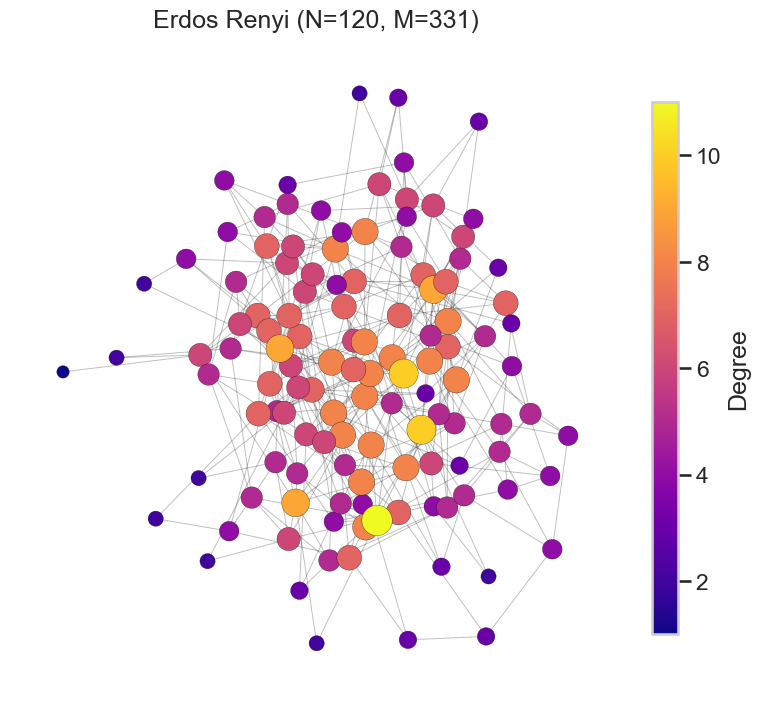

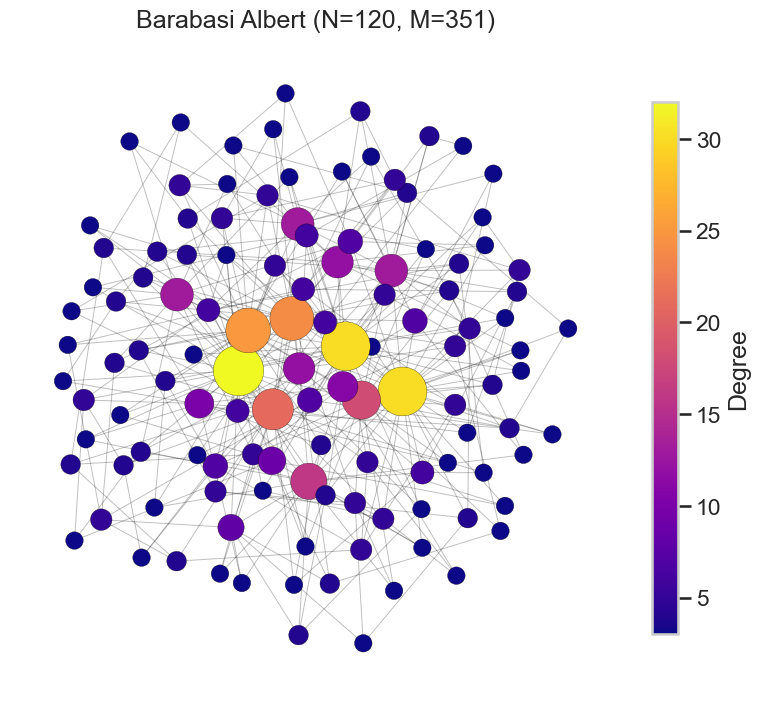

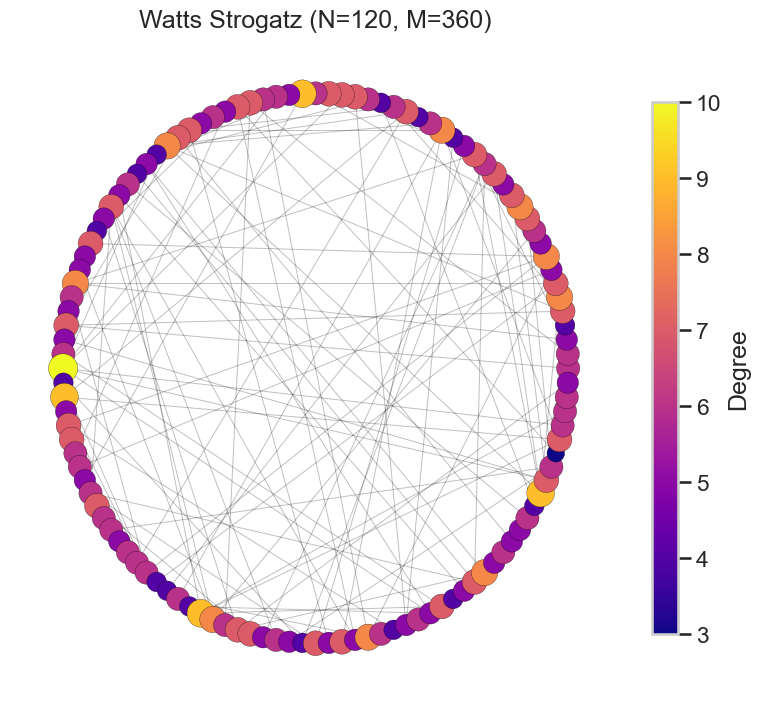

In [94]:
# 1) Show raw network structure
sim = NetworkSimulator(seed=42)
sim.generate_networks(n_nodes=120, n_instances=1, target_k=6.0, ws_p=0.3)

sim.visualize_network('erdos_renyi', instance=0, layout='spring')
sim.visualize_network('barabasi_albert', instance=0, layout='kamada_kawai')
sim.visualize_network('watts_strogatz', instance=0, layout='circular')